In [1]:
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 8))

!make clean

rm -rf *.o *.dSYM/ 01_pod_vector 02_pod_matrix_auto 03_pod_matrix_rowmajor 04_pod_matrix_colmajor 05_matrix_class 06_matrix_vector 07_matrix_matrix 08_gesv 09_geev 10_syev 11_gesvd 12_gels


# Matrix operations

Matrices are everywhere in numerical analysis.  Arrays are the fundamental data structure and used for matrix-vector, matrix-matrix, and other linear algebraic operations.

1. POD arrays and majoring
   1. Vector: 1D array
   1. Matrix: 2D array
   1. Row- and column-majoring
   1. A simple class for matrix
2. Matrix-vector and matrix-matrix operations
   1. Matrix-vector multiplication
   1. Matrix-matrix multiplication
3. Linear algebra
   1. Linear system solution
   1. Eigenvalue and singular value problems
   1. Least square problems

# POD arrays

The plain-old-data (POD) arrays are also called C-style arrays.  They are given the names because they are nothing more than just data and support no mechanism fancier than arithmetic.  We DO, oftentimes, wrap POD with fancy C++ constructs, but all the heavy-lifting numerical calculations still need to be done with POD.  That's how von Neumann computers work.  (It clearly reveals itself in the machine code.)

## Vector: 1D array

A vector is stored as a (usually contiguous) memory buffer of sequetially ordered elements.

```cpp
constexpr size_t width = 5;

double vector[width];

// Populate a vector.
for (size_t i=0; i<width; ++i)
{
    vector[i] = i;
}

std::cout << "vector elements in memory:" << std::endl << " ";
for (size_t i=0; i<width; ++i)
{
    std::cout << " " << vector[i];
}
std::cout << std::endl;
```

In [2]:
!make 01_pod_vector; ./01_pod_vector

g++  -std=c++17 -O3 -g -m64 -I/opt/intel/mkl/include /opt/intel/mkl/lib/libmkl_intel_lp64.a /opt/intel/mkl/lib/libmkl_sequential.a /opt/intel/mkl/lib/libmkl_core.a -lpthread -lm -ldl  -o 01_pod_vector 01_pod_vector.cpp
vector elements in memory:
  0 1 2 3 4


## BLAS

BLAS (basic linear albegra subprograms; a standard set of array manipulation API) defines vector operations as the 1st level.  A partial list of them:

* `SAXPY`: $\mathbf{y} = a\mathbf{x} + \mathbf{y}$, constant times a vector plus a vector
* `SDOT`: $\mathbf{x}\cdot\mathbf{y}$, dot product of two vectors.
* `SNRM2`: $\sqrt{\mathbf{y}\cdot\mathbf{y}}, $Euclidean norm.

The operations are simple enough that we usually don't need to call the library.

## Matrix: 2D array

See how to represent a $5\times5$ square matrix:

\begin{align*}
\mathrm{A} = \left[ a_{ij} \right] = \left(\begin{array}{ccccc}
a_{11} & a_{12} & a_{13} & a_{14} & a_{15} \\
a_{21} & a_{22} & a_{23} & a_{24} & a_{25} \\
a_{31} & a_{32} & a_{33} & a_{34} & a_{35} \\
a_{41} & a_{42} & a_{43} & a_{44} & a_{45} \\
a_{51} & a_{52} & a_{53} & a_{54} & a_{55}
\end{array}\right)
\end{align*}

$i$ is the row index (in the horizontal direction).  $j$ is the column index (in the vertical direction).  If we want to use the 0-based index, it can be rewritten as:

\begin{align*}
\mathrm{A} = \left[ a_{ij} \right] = \left(\begin{array}{ccccc}
a_{00} & a_{01} & a_{02} & a_{03} & a_{04} \\
a_{10} & a_{11} & a_{12} & a_{13} & a_{14} \\
a_{20} & a_{21} & a_{22} & a_{23} & a_{24} \\
a_{30} & a_{31} & a_{32} & a_{33} & a_{34} \\
a_{40} & a_{41} & a_{42} & a_{43} & a_{44}
\end{array}\right)
\end{align*}

In C++ we can use an auto variable like below for the matrix:

```cpp
constexpr size_t width = 5;

double amatrix[width][width];

// Populate the matrix on stack (row-major 2D array).
for (size_t i=0; i<width; ++i) // the i-th row
{
    for (size_t j=0; j<width; ++j) // the j-th column
    {
        amatrix[i][j] = i*10 + j;
    }
}

std::cout << "2D array elements:";
for (size_t i=0; i<width; ++i)
{
    std::cout << std::endl << " ";
    for (size_t j=0; j<width; ++j)
    {
        std::cout << " " << std::setfill('0') << std::setw(2)
                  << amatrix[i][j];
    }
}
std::cout << std::endl;
```

In [3]:
!make 02_pod_matrix_auto; ./02_pod_matrix_auto

g++  -std=c++17 -O3 -g -m64 -I/opt/intel/mkl/include /opt/intel/mkl/lib/libmkl_intel_lp64.a /opt/intel/mkl/lib/libmkl_sequential.a /opt/intel/mkl/lib/libmkl_core.a -lpthread -lm -ldl  -o 02_pod_matrix_auto 02_pod_matrix_auto.cpp
2D array elements:
  00 01 02 03 04
  10 11 12 13 14
  20 21 22 23 24
  30 31 32 33 34
  40 41 42 43 44


The C++ multi-dimensional array index is convenient, but it doesn't always work when the array size isn't known in the compile time.  `g++` accepts the following code, but `clang++` doesn't.

```cpp
void work(double * buffer, size_t width)
{
    // This won't work since width isn't known in compile time.
    double (*matrix)[width] = reinterpret_cast<double (*)[width]>(buffer);
    
    //...
```

In [4]:
# g++ can build; clang++ errors out
!make pod_bad_matrix

g++  -std=c++17 -O3 -g -m64 -I/opt/intel/mkl/include /opt/intel/mkl/lib/libmkl_intel_lp64.a /opt/intel/mkl/lib/libmkl_sequential.a /opt/intel/mkl/lib/libmkl_core.a -lpthread -lm -ldl  -o pod_bad_matrix pod_bad_matrix.cpp
pod_bad_matrix.cpp:7:14: error: cannot initialize a variable of type
      'double (*)[width]' with an rvalue of type 'double (*)[width]'
    double (*matrix)[width] = reinterpret_cast<double (*)[width]>(buffer);
             ^                ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1 error generated.
make: *** [pod_bad_matrix] Error 1


## Row-major 2D variable-size array

The elements of a row-major 2D array are stored so that the fastest changing index is the trailing index of the 2D array:

\begin{align*}
\mathrm{buffer} = [a_{00}, a_{01}, a_{02}, a_{03}, a_{04}, a_{10}, a_{11}, a_{12}, \ldots, a_{43}, a_{44}]
\end{align*}

When accessing the elements, all we need to do is to remember how long we need to *stride* per row (leading) index.

```cpp
constexpr size_t width = 5;

double * buffer = new double[width*width];
double (*matrix)[width] = reinterpret_cast<double (*)[width]>(buffer);
std::cout << "buffer address: " << buffer << std::endl
          << "matrix address: " << matrix << std::endl;

// Populate a buffer (row-major 2D array).
for (size_t i=0; i<width; ++i) // the i-th row
{
    for (size_t j=0; j<width; ++j) // the j-th column
    {
        buffer[i*width + j] = i*10 + j;
    }
}

std::cout << "matrix (row-major) elements as 2D array:";
for (size_t i=0; i<width; ++i)
{
    std::cout << std::endl << " ";
    for (size_t j=0; j<width; ++j)
    {
        std::cout << " " << std::setfill('0') << std::setw(2)
                  << matrix[i][j];
    }
}
std::cout << std::endl;
```

In [5]:
!make 03_pod_matrix_rowmajor; ./03_pod_matrix_rowmajor

g++  -std=c++17 -O3 -g -m64 -I/opt/intel/mkl/include /opt/intel/mkl/lib/libmkl_intel_lp64.a /opt/intel/mkl/lib/libmkl_sequential.a /opt/intel/mkl/lib/libmkl_core.a -lpthread -lm -ldl  -o 03_pod_matrix_rowmajor 03_pod_matrix_rowmajor.cpp
buffer address: 0x7fe95ed00670
matrix address: 0x7fe95ed00670
matrix (row-major) elements as 2D array:
  00 01 02 03 04
  10 11 12 13 14
  20 21 22 23 24
  30 31 32 33 34
  40 41 42 43 44
matrix (row-major) elements in memory:
  00 01 02 03 04 10 11 12 13 14 20 21 22 23 24 30 31 32 33 34 40 41 42 43 44
row majoring: the fastest moving index is the trailing index


## Column-major 2D variable-size array

The elements of a column-major 2D array are stored so that the fastest changing index is the leading index of the 2D array:

\begin{align*}
\mathrm{buffer} = [a_{00}, a_{10}, a_{20}, a_{30}, a_{40}, a_{01}, a_{11}, a_{21}, \ldots, a_{34}, a_{44}]
\end{align*}

Similar to a row-major array, we need to know the stride.  But this time it's for the column (trailing) index.

```cpp
constexpr size_t width = 5;

double * buffer = new double[width*width];
double (*matrix)[width] = reinterpret_cast<double (*)[width]>(buffer);
std::cout << "buffer address: " << buffer << std::endl
          << "matrix address: " << matrix << std::endl;

// Populate a buffer (column-major 2D array).
for (size_t i=0; i<width; ++i) // the i-th row
{
    for (size_t j=0; j<width; ++j) // the j-th column
    {
        buffer[j*width + i] = i*10 + j;
    }
}

std::cout << "matrix (column-major) elements as 2D array:";
for (size_t i=0; i<width; ++i)
{
    std::cout << std::endl << " ";
    for (size_t j=0; j<width; ++j)
    {
        std::cout << " " << std::setfill('0') << std::setw(2)
                  << matrix[j][i];
    }
}
std::cout << std::endl;
```

In [6]:
!make 04_pod_matrix_colmajor; ./04_pod_matrix_colmajor

g++  -std=c++17 -O3 -g -m64 -I/opt/intel/mkl/include /opt/intel/mkl/lib/libmkl_intel_lp64.a /opt/intel/mkl/lib/libmkl_sequential.a /opt/intel/mkl/lib/libmkl_core.a -lpthread -lm -ldl  -o 04_pod_matrix_colmajor 04_pod_matrix_colmajor.cpp
buffer address: 0x7fb22ec018c0
matrix address: 0x7fb22ec018c0
matrix (column-major) elements as 2D array:
  00 01 02 03 04
  10 11 12 13 14
  20 21 22 23 24
  30 31 32 33 34
  40 41 42 43 44
matrix (column-major) elements in memory:
  00 10 20 30 40 01 11 21 31 41 02 12 22 32 42 03 13 23 33 43 04 14 24 34 44
column majoring: the fastest moving index is the leading index


## C++ class to treat the memory buffer like matrix

Keeping track of the stride can be error-prone.  Even if we stick to one majoring order (usually it's row-majoring), it's easy to lose track of it when the number of row and column is different, or it's higher-dimensional.

A common practice in C++ is to use a class to keep track of the stride.  Properly defined accessors significantly simplifies it.

```cpp
class Matrix {

public:

    Matrix(size_t nrow, size_t ncol)
      : m_nrow(nrow), m_ncol(ncol)
    {
        size_t nelement = nrow * ncol;
        m_buffer = new double[nelement];
    }

    // TODO: copy and move constructors and assignment operators.

    ~Matrix()
    {
        delete[] m_buffer;
    }

    // No bound check.
    double   operator() (size_t row, size_t col) const { return m_buffer[row*m_ncol + col]; }
    double & operator() (size_t row, size_t col)       { return m_buffer[row*m_ncol + col]; }

    size_t nrow() const { return m_nrow; }
    size_t ncol() const { return m_ncol; }

private:

    size_t m_nrow;
    size_t m_ncol;
    double * m_buffer;

};
```

In [7]:
!make 05_matrix_class; ./05_matrix_class

g++  -std=c++17 -O3 -g -m64 -I/opt/intel/mkl/include /opt/intel/mkl/lib/libmkl_intel_lp64.a /opt/intel/mkl/lib/libmkl_sequential.a /opt/intel/mkl/lib/libmkl_core.a -lpthread -lm -ldl  -o 05_matrix_class 05_matrix_class.cpp
matrix:
  00 01 02 03 04
  10 11 12 13 14
  20 21 22 23 24
  30 31 32 33 34
  40 41 42 43 44


# Matrix-vector multiplication

BLAS level 2 includes matrix-vector operations.

Operations of a matrix and a vector is much more interesting than vector operations.  What we really need to do is the matrix-vector multiplication

\begin{align*}
\mathbf{y} = \mathrm{A}\mathbf{x}
\end{align*}

But because a matrix is a 2D array, we should first discuss traspose.  Write a $m\times n$ ($m$ rows and $n$ columns) matrix $\mathrm{A}$

\begin{align*}
\mathrm{A} = [a_{ij}] = \left(\begin{array}{cccc}
a_{11} & a_{12} & \cdots & a_{1n} \\
a_{21} & a_{22} & \cdots & a_{2n} \\
a_{31} & a_{32} & \cdots & a_{3n} \\
\vdots & & \ddots & \vdots \\
a_{m1} & a_{m2} & \cdots & a_{mn}
\end{array}\right)_{m\times n}
\end{align*}

its transpose $\mathrm{A}^t$ becomes a $n\times m$ ($n$ rows and $m$ columns) matrix

\begin{align*}
\mathrm{A}^t = [a_{ji}] = \left(\begin{array}{ccccc}
a_{11} & a_{21} & a_{31} & \cdots & a_{m1} \\
a_{12} & a_{22} & a_{32} & \cdots & a_{m2} \\
\vdots & & & \ddots & \vdots \\
a_{1n} & a_{2n} & a_{3n} & \cdots & a_{mn}
\end{array}\right)_{n\times m}
\end{align*}

Fast transpose can be done by taking advantage of majoring.  The key is the formula $\mathrm{A}^t = [a_{ji}]$ for $\mathrm{A} = [a_{ij}]$.  The code is like:

```cpp
double   operator() (size_t row, size_t col) const { return m_buffer[index(row, col)]; }
double & operator() (size_t row, size_t col)       { return m_buffer[index(row, col)]; }

bool is_transposed() const { return m_transpose; }

Matrix & transpose()
{
    m_transpose = !m_transpose;
    std::swap(m_nrow, m_ncol);
    return *this;
}
```

There is no data copied for transpose.  The price to pay is the if statement in the indexing helper.

```cpp
size_t index(size_t row, size_t col) const
{
    if (m_transpose) { return row          + col * m_nrow; }
    else             { return row * m_ncol + col         ; }
}
```

Come back to the matrix-vector multiplication, $\mathbf{y} = \mathrm{A}\mathbf{x}$.  The calculation is easy by using the index form of the matrix and vector.

\begin{align*}
y_i = \sum_{j=1}^n A_{ij} x_j, \quad i = 1, \ldots, m
\end{align*}

Sometimes, when Einstein's summation convention is applied, the summation sign may be suppressed, and the repeated indices imply summation

\begin{align*}
y_i = A_{ij} x_j, \quad i = 1, \ldots, m, \; j = 1, \ldots, n
\end{align*}

It can be shown that the index form of $\mathbf{y}' = \mathrm{A}^t\mathbf{x}'$ is

\begin{align*}
y'_j = A_{ji} x'_i, \quad i = 1, \ldots, m, \; j = 1, \ldots, n
\end{align*}

Implement a naive matrix-vector multiplication:

```cpp
std::vector<double> operator*(Matrix const & mat, std::vector<double> const & vec)
{
    if (mat.ncol() != vec.size())
    {
        throw std::out_of_range("matrix column differs from vector size");
    }

    std::vector<double> ret(mat.nrow());

    for (size_t i=0; i<mat.nrow(); ++i)
    {
        double v = 0;
        for (size_t j=0; j<mat.ncol(); ++j)
        {
            v += mat(i,j) * vec[j];
        }
        ret[i] = v;
    }

    return ret;
}
```

In [8]:
!make 06_matrix_vector; ./06_matrix_vector

g++  -std=c++17 -O3 -g -m64 -I/opt/intel/mkl/include /opt/intel/mkl/lib/libmkl_intel_lp64.a /opt/intel/mkl/lib/libmkl_sequential.a /opt/intel/mkl/lib/libmkl_core.a -lpthread -lm -ldl  -o 06_matrix_vector 06_matrix_vector.cpp
>>> square matrix-vector multiplication:
matrix A:
   1  0  0  0  0
   0  1  0  0  0
   0  0  1  0  0
   0  0  0  1  0
   0  0  0  0  1
vector b: 1 0 0 0 0
A*b = 1 0 0 0 0
>>> m*n matrix-vector multiplication:
matrix A:
   1  2  3
   4  5  6
vector b: 1 2 3
A*b = 14 32
>>> transposed matrix-vector multiplication:
matrix A:
   1  4
   2  5
   3  6
matrix A buffer: 1 2 3 4 5 6
vector b: 1 2
A*b = 9 12 15
>>> copied transposed matrix-vector multiplication:
matrix A:
   1  4
   2  5
   3  6
matrix A buffer: 1 4 2 5 3 6
vector b: 1 2
A*b = 9 12 15


The majoring may significantly affects the speed of matrix-vector multiplication.

# Matrix-matrix multiplication

BLAS level 3 includes matrix-matrix operations.

Matrix-matrix multiplication, $\mathrm{C} = \mathrm{A}\mathrm{B}$ generally uses a $O(n^3)$ algorithm for $O(n^2)$ data.  The formula is

\begin{align*}
C_{ik} = \sum_{j=1}^n A_{ij}B_{jk}, \quad i = 1, \ldots, m, \; k = 1, \ldots, l
\end{align*}

or, by using Einstein's summation convention,

\begin{align*}
C_{ik} = A_{ij}B_{jk}, \quad i = 1, \ldots, m, \; j = 1, \ldots, n, \; k = 1, \ldots, l
\end{align*}

A naive C++ implementation:

```cpp
Matrix operator*(Matrix const & mat1, Matrix const & mat2)
{
    if (mat1.ncol() != mat2.nrow())
    {
        throw std::out_of_range(
            "the number of first matrix column "
            "differs from that of second matrix row");
    }

    Matrix ret(mat1.nrow(), mat2.ncol());

    for (size_t i=0; i<ret.nrow(); ++i)
    {
        for (size_t k=0; k<ret.ncol(); ++k)
        {
            double v = 0;
            for (size_t j=0; j<mat1.ncol(); ++j)
            {
                v += mat1(i,j) * mat2(j,k);
            }
            ret(i,k) = v;
        }
    }

    return ret;
}
```

In [9]:
!make 07_matrix_matrix; ./07_matrix_matrix

g++  -std=c++17 -O3 -g -m64 -I/opt/intel/mkl/include /opt/intel/mkl/lib/libmkl_intel_lp64.a /opt/intel/mkl/lib/libmkl_sequential.a /opt/intel/mkl/lib/libmkl_core.a -lpthread -lm -ldl  -o 07_matrix_matrix 07_matrix_matrix.cpp
>>> A(2x3) times B(3x2):
matrix A (2x3):
   1  2  3
   4  5  6
matrix B (3x2):
   1  2
   3  4
   5  6
result matrix C (2x2) = AB:
  22 28
  49 64
>>> B(3x2) times A(2x3):
matrix B (3x2):
   1  2
   3  4
   5  6
matrix A (2x3):
   1  2  3
   4  5  6
result matrix D (3x3) = BA:
   9 12 15
  19 26 33
  29 40 51


Matrix-matrix multiplication is intensive number-crunching.  The naive, brute-force, n-cube algorithm is basically what we need to do, without a way around.

It also demands memory.  A matrix of $100,000\times100,000$ takes $10,000,000,000$ (i.e., $10^{10}$) elements, and with double-precision floating points, it takes 80 GB.  To perform multiplication, you need the memory for 3 of the matrices, and that's 240 GB.  The dense matrix multiplication generally cannot use distributed memory without significantly loss of runtime speed.  The reasonable size of dense matrices for a workstation is around $10,000\times10,000$, i.e., 800 MB per matrix.  It's very limiting, but already facilitates a good number of applications.

# Linear algebra

After the matrix operations, it is time to introduce linear algebra in C++.  There are two critically important software packages: BLAS (http://www.netlib.org/blas/) and LAPACK (http://www.netlib.org/lapack/).  They were developed in FORTRAN.  Although the FORTRAN code is still being maintained today, it serves more like a reference implementation.  Multiple vendors provide optimized implementation, e.g., Intel's Math Kernel Library (MKL), Apple's vecLib, etc.

BLAS stands for Basic Linear Algebra Subprograms, and LAPACK is Linear Algebra PACKage.  LAPACK is designed to rely on the underneath BLAS, so the two libraries are usually used together.  For example, the general matrix-vector multiplication is defined as the `?GEMV` function in BLAS level 2 (`?` can be one of `S`, `D`, `C`, and `Z`, for single-precision real, double-precision real, single-precision complex, and double-precision complex, respectively), and the general matrix-matrix multiplication is the `?GEMM` function in BLAS level 3.

While BLAS offers basic operations like matrix multiplication, LAPACK provides more versatile computation helpers or solvers, e.g., a system of linear equations, least square, and eigen problems.

Both BLAS and LAPACK provide C interface.  They don't native C++ interface, but the C interface is compatible to C++.  CBLAS is the C interface for BLAS, and LAPACKE is that for LAPACK.

## Linear system

LAPACK provides `?GESV` functions to solve a linear system using a general (dense) matrix: $\mathrm{A}\mathbf{x} = \mathbf{b}$.  Say we have a system of linear equations:

\begin{align*}
3 x_1 + 5 x_2 + 2 x_3 &= 57 \\
2 x_1 +   x_2 + 3 x_3 &= 22 \\
4 x_1 + 3 x_2 + 2 x_3 &= 41
\end{align*}

It can be rewritten as $\mathrm{A}\mathbf{x} = \mathbf{b}$, where

\begin{align*}
\mathrm{A} = \left(\begin{array}{ccc}
3 & 5 & 2 \\
2 & 1 & 3 \\
4 & 3 & 2
\end{array}\right), \quad
\mathbf{b} = \left(\begin{array}{c}
57 \\ 22 \\ 41
\end{array}\right), \quad
\mathbf{x} = \left(\begin{array}{c}
x_1 \\ x_2 \\ x_3
\end{array}\right)
\end{align*}

Note that the reference implementation of LAPACK is FORTRAN, which uses column major.  The dimensional arguments of the LAPACK subroutines changes meaning when we call them from C with row-major matrices.

```cpp
const size_t n = 3;
int status;

std::cout << ">>> Solve Ax=b (row major)" << std::endl;
Matrix mat(n, n, false);
mat(0,0) = 3; mat(0,1) = 5; mat(0,2) = 2;
mat(1,0) = 2; mat(1,1) = 1; mat(1,2) = 3;
mat(2,0) = 4; mat(2,1) = 3; mat(2,2) = 2;
Matrix b(n, 2, false);
b(0,0) = 57; b(0,1) = 23;
b(1,0) = 22; b(1,1) = 12;
b(2,0) = 41; b(2,1) = 84;
std::vector<int> ipiv(n);

std::cout << "A:" << mat << std::endl;
std::cout << "b:" << b << std::endl;

status = LAPACKE_dgesv(
    LAPACK_ROW_MAJOR // int matrix_layout
  , n // lapack_int n
  , b.ncol() // lapack_int nrhs
  , mat.data() // double * a
  , mat.ncol() // lapack_int lda
  , ipiv.data() // lapack_int * ipiv
  , b.data() // double * b
  , b.ncol() // lapack_int ldb
  // for row major matrix, ldb becomes the trailing dimension.
);

std::cout << "solution x:" << b << std::endl;
std::cout << "dgesv status: " << status << std::endl;

std::cout << ">>> Solve Ax=b (column major)" << std::endl;
Matrix mat2 = Matrix(n, n, true);
mat2(0,0) = 3; mat2(0,1) = 5; mat2(0,2) = 2;
mat2(1,0) = 2; mat2(1,1) = 1; mat2(1,2) = 3;
mat2(2,0) = 4; mat2(2,1) = 3; mat2(2,2) = 2;
Matrix b2(n, 2, true);
b2(0,0) = 57; b2(0,1) = 23;
b2(1,0) = 22; b2(1,1) = 12;
b2(2,0) = 41; b2(2,1) = 84;

std::cout << "A:" << mat2 << std::endl;
std::cout << "b:" << b2 << std::endl;

status = LAPACKE_dgesv(
    LAPACK_COL_MAJOR // int matrix_layout
  , n // lapack_int n
  , b2.ncol() // lapack_int nrhs
  , mat2.data() // double * a
  , mat2.nrow() // lapack_int lda
  , ipiv.data() // lapack_int * ipiv
  , b2.data() // double * b
  , b2.nrow() // lapack_int ldb
  // for column major matrix, ldb remains the leading dimension.
);

std::cout << "solution x:" << b2 << std::endl;
std::cout << "dgesv status: " << status << std::endl;
```

In [10]:
!make 08_gesv; ./08_gesv

g++  -std=c++17 -O3 -g -m64 -I/opt/intel/mkl/include /opt/intel/mkl/lib/libmkl_intel_lp64.a /opt/intel/mkl/lib/libmkl_sequential.a /opt/intel/mkl/lib/libmkl_core.a -lpthread -lm -ldl  -o 08_gesv 08_gesv.cpp
>>> Solve Ax=b (row major)
A:
   3  5  2
   2  1  3
   4  3  2
 data:   3  5  2  2  1  3  4  3  2
b:
  57 23
  22 12
  41 84
 data:  57 23 22 12 41 84
solution x:
   2 38.3913
   9 -11.3043
   3 -17.8261
 data:   2 38.3913  9 -11.3043  3 -17.8261
dgesv status: 0
>>> Solve Ax=b (column major)
A:
   3  5  2
   2  1  3
   4  3  2
 data:   3  2  4  5  1  3  2  3  2
b:
  57 23
  22 12
  41 84
 data:  57 22 41 23 12 84
solution x:
   2 38.3913
   9 -11.3043
   3 -17.8261
 data:   2  9  3 38.3913 -11.3043 -17.8261
dgesv status: 0


## Eigenvalue problems and SVD

Eigenvalue problems and SVD are popular ways to factorize matrices.  The eigenvalue problems are to find the eigenvalues $\lambda_1, \lambda_2, \ldots, \lambda_n$ and the eigenvector matrix $\mathrm{S}$ of a matrix $\mathrm{A}$, such that

\begin{align*}
\mathrm{A} = \mathrm{S}\mathrm{\Lambda}\mathrm{S}^{-1}
\end{align*}

An eigenvalue $\lambda$ of $\mathrm{A}$ is a scalar such that

\begin{align*}
\mathrm{A}v = \lambda v
\end{align*}

$v$ is an eigenvector associated with $\lambda$.  Because $v$ is after $\mathrm{A}$, it is also called right eigenvector.  For the same eigenvalue $\lambda$, the left eigenvector can be found by the following equation

\begin{align*}
u^h\mathrm{A} = \lambda u^h
\end{align*}

Use LAPACK's high-level `?GEEV` driver for calculating the eigenvalues and eigenvectors:

```cpp
const size_t n = 3;
int status;

std::cout << ">>> Solve Ax=lx (row major)" << std::endl;
Matrix mat(n, n, false);
mat(0,0) = 3; mat(0,1) = 5; mat(0,2) = 2;
mat(1,0) = 2; mat(1,1) = 1; mat(1,2) = 3;
mat(2,0) = 4; mat(2,1) = 3; mat(2,2) = 2;
std::vector<double> wr(n), wi(n);
Matrix vl(n, n, false), vr(n, n, false);

std::vector<int> ipiv(n);

std::cout << "A:" << mat << std::endl;

status = LAPACKE_dgeev(
    LAPACK_ROW_MAJOR // int matrix_layout
  , 'V' // char jobvl; 'V' to compute left eigenvectors, 'N' to not compute them
  , 'V' // char jobvr; 'V' to compute right eigenvectors, 'N' to not compute them
  , n // lapack_int n
  , mat.data() // double * a
  , mat.ncol() // lapack_int lda
  , wr.data() // double * wr
  , wi.data() // double * wi
  , vl.data() // double * vl
  , vl.ncol() // lapack_int ldvl
  , vr.data() // double * vr
  , vr.ncol() // lapack_int ldvr
);
```

In [11]:
!make 09_geev; ./09_geev

g++  -std=c++17 -O3 -g -m64 -I/opt/intel/mkl/include /opt/intel/mkl/lib/libmkl_intel_lp64.a /opt/intel/mkl/lib/libmkl_sequential.a /opt/intel/mkl/lib/libmkl_core.a -lpthread -lm -ldl  -o 09_geev 09_geev.cpp
>>> Solve Ax=lx (row major)
A:
   3  5  2
   2  1  3
   4  3  2
 data:   3  5  2  2  1  3  4  3  2
dgeev status: 0
eigenvalues:
      (real)      (imag)
(   8.270757,   0.000000)
(  -1.135379,   1.221392)
(  -1.135379,  -1.221392)
left eigenvectors:
    0.609288 ( -0.012827, -0.425749) ( -0.012827,  0.425749)
    0.621953 (  0.652142,  0.000000) (  0.652142,  0.000000)
    0.491876 ( -0.442811,  0.444075) ( -0.442811, -0.444075)
right eigenvectors:
    0.649714 ( -0.668537,  0.000000) ( -0.668537,  0.000000)
    0.435736 (  0.448552, -0.330438) (  0.448552,  0.330438)
    0.622901 (  0.260947,  0.417823) (  0.260947, -0.417823)


Verify the calculation:

In [12]:
import numpy as np

A = np.array([[3, 5, 2], [2, 1, 3], [4, 3, 2]], dtype='float64')

xl = np.array([0.609288, 0.621953, 0.491876], dtype='float64')
print("Verify the left eigenvector with the first eigenvalue:")
print("  x^t A:", np.dot(xl, A))
print("  l x^t:", 8.27076*xl)

Verify the left eigenvector with the first eigenvalue:
  x^t A: [5.039274 5.144021 4.068187]
  l x^t: [5.03927482 5.14402399 4.06818835]


In [13]:
print("Verify the left eigenvector with the second eigenvalue (complex-valued):")

xl = np.array([-0.012827-0.425749j, 0.652142, -0.442811+0.444075j], dtype='complex64')
# NOTE: the left eigenvector needs the conjugate.
print("  x^h A:", np.dot(xl.conj(), A))
print("  l x^h:", (-1.135379+1.221392j)*xl.conj())

Verify the left eigenvector with the second eigenvalue (complex-valued):
  x^h A: [-0.50544107-0.49905294j -0.74042605+0.79652005j  1.04514994-0.03665197j]
  l x^h: [-0.5054429 -0.49905324j -0.74042827+0.796521j    1.0451479 -0.03665245j]


In [14]:
print("Verify the right eigenvector with the first eigenvalue:")

xr = np.array([0.649714, 0.435736, 0.622901], dtype='float64')
print("  A x:", np.dot(A, xr))
print("  l x:", 8.27076*xr)

Verify the right eigenvector with the first eigenvalue:
  A x: [5.373624 3.603867 5.151866]
  l x: [5.37362856 3.60386788 5.15186467]


In [15]:
print("Verify the right eigenvector with the second eigenvalue (complex-valued):")

xr = np.array([-0.668537, 0.448552-0.330438j, 0.260947+0.417823j], dtype='complex64')
print("  A x:", np.dot(A, xr))
print("  l x:", (-1.135379+1.221392j)*xr)

Verify the right eigenvector with the second eigenvalue (complex-valued):
  A x: [ 0.75904298-0.81654397j -0.10568106+0.92303097j -0.80659807-0.15566799j]
  l x: [ 0.75904286-0.8165458j  -0.10568219+0.92303026j -0.8065994 -0.15566885j]


LAPACK's `?SYEV` calculates the eigenvalues and eigenvectors for symmetric matrices.

```cpp
const size_t n = 3;
int status;

std::cout << ">>> Solve Ax=lx (row major, A symmetrix)" << std::endl;
Matrix mat(n, n, false);
mat(0,0) = 3; mat(0,1) = 5; mat(0,2) = 2;
mat(1,0) = 5; mat(1,1) = 1; mat(1,2) = 3;
mat(2,0) = 2; mat(2,1) = 3; mat(2,2) = 2;
std::vector<double> w(n);

std::cout << "A:" << mat << std::endl;

status = LAPACKE_dsyev(
    LAPACK_ROW_MAJOR // int matrix_layout
  , 'V' // char jobz; 'V' to compute both eigenvalues and eigenvectors, 'N' only eigenvalues
  , 'U' // char uplo; 'U' use the upper triangular of input a, 'L' use the lower
  , n // lapack_int n
  , mat.data() // double * a
  , mat.ncol() // lapack_int lda
  , w.data() // double * w
);
```

In [16]:
!make 10_syev; ./10_syev

g++  -std=c++17 -O3 -g -m64 -I/opt/intel/mkl/include /opt/intel/mkl/lib/libmkl_intel_lp64.a /opt/intel/mkl/lib/libmkl_sequential.a /opt/intel/mkl/lib/libmkl_core.a -lpthread -lm -ldl  -o 10_syev 10_syev.cpp
>>> Solve Ax=lx (row major, A symmetrix)
A:
   3  5  2
   5  1  3
   2  3  2
 data:   3  5  2  5  1  3  2  3  2
dsyev status: 0
eigenvalues:  -3.36105 0.503874 8.85717
eigenvectors:
  -0.551825 -0.505745 -0.663107
  0.798404 -0.0906812 -0.595255
  -0.240916 0.857904 -0.453828
 data:  -0.551825 -0.505745 -0.663107 0.798404 -0.0906812 -0.595255 -0.240916 0.857904 -0.453828


In [17]:
print("Verify the right eigenvectors with the eigenvalues:")

A = np.array([[3, 5, 2], [5, 1, 3], [2, 3, 2]], dtype='float64')

print("First eigenvalue:")
x = np.array([-0.551825, 0.798404, -0.240916], dtype='float64')
print("  A x:", np.dot(A, x))
print("  l x:", -3.36105*x)

print("Second eigenvalue:")
x = np.array([-0.505745, -0.0906812, 0.857904], dtype='float64')
print("  A x:", np.dot(A, x))
print("  l x:", 0.503874*x)

print("Third eigenvalue:")
x = np.array([-0.663107, -0.595255, -0.453828], dtype='float64')
print("  A x:", np.dot(A, x))
print("  l x:", 8.85717*x)

Verify the right eigenvectors with the eigenvalues:
First eigenvalue:
  A x: [ 1.854713 -2.683469  0.80973 ]
  l x: [ 1.85471142 -2.68347576  0.80973072]
Second eigenvalue:
  A x: [-0.254833  -0.0456942  0.4322744]
  l x: [-0.25483176 -0.0456919   0.43227552]
Third eigenvalue:
  A x: [-5.873252 -5.272274 -4.019635]
  l x: [-5.87325143 -5.27227473 -4.01963175]


In [18]:
# The eigenvector matrix is orthogonal; the right eigenvectors are also the left eigenvectors
print("Verify the left eigenvectors with the eigenvalues:")

print("First (left) eigenvector:")
x = np.array([-0.551825, 0.798404, -0.240916], dtype='float64')
print("  x^t A:", np.dot(x, A))
print("  l x^t:", -3.36105*x)

print("Second (left) eigenvector:")
x = np.array([-0.505745, -0.0906812, 0.857904], dtype='float64')
print("  x^t A:", np.dot(x, A))
print("  l x^t:", 0.503874*x)

print("Third (left) eigenvector:")
x = np.array([-0.663107, -0.595255, -0.453828], dtype='float64')
print("  x^t A:", np.dot(x, A))
print("  l x^t:", 8.85717*x)

Verify the left eigenvectors with the eigenvalues:
First (left) eigenvector:
  x^t A: [ 1.854713 -2.683469  0.80973 ]
  l x^t: [ 1.85471142 -2.68347576  0.80973072]
Second (left) eigenvector:
  x^t A: [-0.254833  -0.0456942  0.4322744]
  l x^t: [-0.25483176 -0.0456919   0.43227552]
Third (left) eigenvector:
  x^t A: [-5.873252 -5.272274 -4.019635]
  l x^t: [-5.87325143 -5.27227473 -4.01963175]


Singular value decomposition is like eigenvalue problems.  Instead of obtaining the eigenvalue and the eigenvector matrices, SVD is to obtain the singular value and the left and right singular vector matrix

\begin{align*}
\mathrm{A}_{m\times n} = \mathrm{U}_{m\times m}\mathrm{\Sigma}_{m\times n}\mathrm{V}_{n\times n}^t
\end{align*}

where $\mathrm{U}$ is the eigenvector matrix of $\mathrm{A}\mathrm{A}^t$, $\mathrm{V}$ the eigenvector matrix of $\mathrm{A}^t\mathrm{A}$, and $\mathrm{\Sigma}$ a diagonal matrix whose values are the square root of the non-zero eigenvalues of $\mathrm{A}\mathrm{A}^t$ or $\mathrm{A}^t\mathrm{A}$.

The singular values $\sigma_1, \sigma_2, \ldots, \sigma_r$ of $\mathrm{A}$ are the diagonal values of $\mathrm{\Sigma}$.  In the SVD problem, the matrix $\mathrm{A}$ may be rectangular instead of square.

Use LAPACK's `?GESVD`to compute SVD:

```cpp
const size_t m = 3, n = 4;
int status;

std::cout << ">>> SVD" << std::endl;
Matrix mat(m, n, false);
mat(0,0) = 3; mat(0,1) = 5; mat(0,2) = 2; mat(0, 3) = 6;
mat(1,0) = 2; mat(1,1) = 1; mat(1,2) = 3; mat(1, 3) = 2;
mat(2,0) = 4; mat(2,1) = 3; mat(2,2) = 2; mat(2, 3) = 4;
std::vector<double> s(m), superb(m);
Matrix u(m, m, false);
Matrix vt(n, n, false);

std::cout << "A:" << mat << std::endl;

status = LAPACKE_dgesvd(
    LAPACK_ROW_MAJOR // int matrix_layout;
  , 'A' // char jobu;
  , 'A' // char jobvt;
  , m // lapack_int m
  , n // lapack_int n
  , mat.data() // double * a
  , mat.ncol() // lapack_int lda
  , s.data() // double * s
  , u.data() // double * u
  , u.ncol() // lapack_int ldu
  , vt.data() // double * vt
  , vt.ncol() // lapack_int ldvt
  , superb.data() // double * superb
);
```

In [19]:
!make 11_gesvd; ./11_gesvd

g++  -std=c++17 -O3 -g -m64 -I/opt/intel/mkl/include /opt/intel/mkl/lib/libmkl_intel_lp64.a /opt/intel/mkl/lib/libmkl_sequential.a /opt/intel/mkl/lib/libmkl_core.a -lpthread -lm -ldl  -o 11_gesvd 11_gesvd.cpp
>>> SVD
A:
           3          5          2          6
           2          1          3          2
           4          3          2          4
 data:  3 5 2 6 2 1 3 2 4 3 2 4
dgesvd status: 0
singular values:  11.3795 2.45858 1.20947
u: 
   -0.745981  -0.530655   -0.40239
   -0.324445   0.817251  -0.476274
   -0.581591   0.224738   0.781822
 data:  -0.745981 -0.530655 -0.40239 -0.324445 0.817251 -0.476274 -0.581591 0.224738 0.781822
vt: 
   -0.458123  -0.509612  -0.318862  -0.654787
     0.38294  -0.472553   0.748366  -0.264574
    0.799992  -0.118035  -0.553927  -0.198105
  -0.0591054  -0.709265  -0.177316   0.679712
 data:  -0.458123 -0.509612 -0.318862 -0.654787 0.38294 -0.472553 0.748366 -0.264574 0.799992 -0.118035 -0.553927 -0.198105 -0.0591054 -0.709265 -0.177316 0.67

In [20]:
import pprint

print("Verify the results:")

a = np.array(
    [
        [3, 5, 2, 6],
        [2, 1, 3, 2],
        [4, 3, 2, 4],
    ], dtype='float64')

u = np.array(
    [
        [-0.745981, -0.530655, -0.40239],
        [-0.324445,  0.817251, -0.476274],
        [-0.581591,  0.224738, 0.781822],
    ], dtype='float64')
s = np.array(
    [
        [11.3795,       0,       0, 0],
        [      0, 2.45858,       0, 0],
        [      0,       0, 1.20947, 0],
    ], dtype='float64'
)
vt = np.array(
    [
        [-0.458123, -0.509612, -0.318862, -0.654787],
        [  0.38294, -0.472553,  0.748366, -0.264574],
        [ 0.799992, -0.118035, -0.553927, -0.198105],
        [-0.0591054,-0.709265, -0.177316,  0.679712],
    ], dtype='float64'
)

print("A:")
pprint.pprint(a)
print("USV^t:")
pprint.pprint(np.dot(np.dot(u, s), vt))
print("error:")
pprint.pprint(np.abs(np.dot(np.dot(u, s), vt) - a))

Verify the results:
A:
array([[3., 5., 2., 6.],
       [2., 1., 3., 2.],
       [4., 3., 2., 4.]])
USV^t:
array([[3.00001146, 5.00000567, 2.00000761, 6.00000733],
       [2.00000598, 1.00000157, 3.00000366, 2.00000171],
       [4.00000932, 3.00000622, 2.00000865, 4.00000809]])
error:
array([[1.14555417e-05, 5.66863979e-06, 7.61360053e-06, 7.32884776e-06],
       [5.97550818e-06, 1.57297897e-06, 3.66276266e-06, 1.71457387e-06],
       [9.32111966e-06, 6.21632203e-06, 8.64943021e-06, 8.09395774e-06]])


In [21]:
print("Keep the 2 most significant singular values:")

smost = np.array(
    [
        [11.3795,       0, 0, 0],
        [      0, 2.45858, 0, 0],
        [      0,       0, 0, 0],
    ], dtype='float64'
)
rebuilt = np.dot(np.dot(u, smost), vt)
print("USV^t:")
pprint.pprint(rebuilt)
print("error:")
pprint.pprint(np.abs(rebuilt - a))
print()

print("Keep the 2 least significant singular values:")
sleast = np.array(
    [
        [0,       0,       0, 0],
        [0, 2.45858,       0, 0],
        [0,       0, 1.20947, 0],
    ], dtype='float64'
)
rebuilt = np.dot(np.dot(u, sleast), vt)
print("USV^t:")
pprint.pprint(rebuilt)
print("error:")
pprint.pprint(np.abs(rebuilt - a))

Keep the 2 most significant singular values:
USV^t:
array([[3.38935047, 4.94256056, 1.73042318, 5.90359386],
       [2.46083266, 0.9320088 , 2.68092004, 1.88588549],
       [3.24354468, 3.11161896, 2.52379662, 4.18733425]])
error:
array([[0.38935047, 0.05743944, 0.26957682, 0.09640614],
       [0.46083266, 0.0679912 , 0.31907996, 0.11411451],
       [0.75645532, 0.11161896, 0.52379662, 0.18733425]])

Keep the 2 least significant singular values:
USV^t:
array([[-0.88894466,  0.67396506, -0.70677708,  0.441592  ],
       [ 0.30860584, -0.88149708,  1.82275818, -0.41748621],
       [ 0.96805291, -0.37271546, -0.11028855, -0.33351291]])
error:
array([[3.88894466, 4.32603494, 2.70677708, 5.558408  ],
       [1.69139416, 1.88149708, 1.17724182, 2.41748621],
       [3.03194709, 3.37271546, 2.11028855, 4.33351291]])


In [22]:
print("Keep only the most significant singular values:")

s1 = np.array(
    [
        [11.3795, 0, 0, 0],
        [      0, 0, 0, 0],
        [      0, 0, 0, 0],
    ], dtype='float64'
)
print("USV^t:")
pprint.pprint(np.dot(np.dot(u, s1), vt))
print("error:")
pprint.pprint(np.abs(np.dot(np.dot(u, s1), vt)-a))

Keep only the most significant singular values:
USV^t:
array([[3.88895612, 4.32604061, 2.70678469, 5.55841533],
       [1.69140014, 1.88149865, 1.17724548, 2.41748793],
       [3.03195641, 3.37272167, 2.1102972 , 4.333521  ]])
error:
array([[0.88895612, 0.67395939, 0.70678469, 0.44158467],
       [0.30859986, 0.88149865, 1.82275452, 0.41748793],
       [0.96804359, 0.37272167, 0.1102972 , 0.333521  ]])


## Least square

Find a function of the form

\begin{align*}
f(x) = a_1g_1(x) + a_2g_2(x) + \ldots + a_ng_n(x) = \sum_{j=1}^na_ng_n(x)
\end{align*}

that mininmizes the cost function

\begin{align*}
\Phi(\mathbf{a}) = \sum_{i=1}^m \left[ f(x_i; \mathbf{a}) - y_i \right]^2
\end{align*}

for given points $(x_i, y_i)$, $i=1, 2, \ldots, m$.

Write

\begin{align*}
\newcommand{\defeq}{\overset{\text{def}}{=}}
f_i &= f(x_i) = (\mathrm{J}\mathbf{a})_i \\
\mathrm{J} &\defeq \left[\begin{array}{cccc}
g_1(x_1) & g_2(x_1) & \ldots & g_n(x_1) \\
g_1(x_2) & g_2(x_2) & \ldots & g_n(x_2) \\
\vdots & & \ddots &\vdots \\
g_1(x_m) & g_2(x_m) & \ldots & g_n(x_m)
\end{array}\right]
= \left[g_j(x_i)\right], \; i=1, \ldots, m, \; j=1, \ldots, n
\end{align*}

The linear least-square problem can be expressed in the matrix-vector form

\begin{align*}
\min(\Phi) = \min(\mathrm{J}\mathbf{a} - \mathbf{y})^2
\end{align*}

For the minimum of the convex function $\Phi$ to exist, $\nabla_a\Phi = 0$.  Use Einstein's summation convention with the index form

\begin{align*}
\Phi = (\mathrm{J}_{ij}a_j - y_i)^2
\end{align*}

\begin{align*}
\nabla\Phi &= \frac{\partial}{\partial a_j}(\mathrm{J}_{ik}a_k-y_i)^2
= 2(\mathrm{J}_{ik}a_k-y_i)\frac{\partial(\mathrm{J}_{ik}a_k)}{\partial a_j}
= 2(\mathrm{J}_{ik}a_k-y_i)\mathrm{J}_{ij}
= 2\mathrm{J}^t_{ji}(\mathrm{J}_{ik}a_k-y_i) = 0
\end{align*}

Rewrite in the vector form and obtain the normal equation for $\mathbf{a}$

\begin{align*}
\mathrm{J}^t\mathrm{J}\mathbf{a} = \mathrm{J}^t\mathrm{y}
\end{align*}

Let's test the LAPACK `?GELS` function, which find the approximated solution of an over- or under-determined linear system, $\min(\mathrm{J}\mathbf{a}-\mathbf{y})^2$, where $\mathbf{a}$ is the unknown.

Given 4 data points $(1, 17)$, $(2, 58)$, $(3, 165)$, $(4, 360)$.  We want to find the closest curve of the function $f(x) = a_1x^3 + a_2x_2 + a_3x$.  The linear system is

\begin{align*}
\mathrm{J} = \left[\begin{array}{ccc}
  1 & 1 & 1 \\
  8 & 4 & 2 \\
  27 & 9 & 3 \\
  64 & 16 & 4
\end{array}\right]
\end{align*}

and the right-hand side is

\begin{align*}
\mathbf{y} = \left[\begin{array}{ccc}
  17 \\ 58 \\ 165 \\ 360
\end{array}\right]
\end{align*}

```cpp
const size_t m = 4, n = 3;
int status;

std::cout << ">>> least square" << std::endl;
// Use least-square to fit the data of (x, y) tuple:
// (1, 17), (2, 58), (3, 165), (4, 360) to
// the equation: a_1 x^3 + a_2 x^2 + a_3 x.
Matrix mat(m, n, false);
mat(0,0) = 1; mat(0,1) = 1; mat(0,2) = 1;
mat(1,0) = 8; mat(1,1) = 4; mat(1,2) = 2;
mat(2,0) = 27; mat(2,1) = 9; mat(2,2) = 3;
mat(3,0) = 64; mat(3,1) = 16; mat(3,2) = 4;
std::vector<double> y{17, 58, 165, 360};
// The equation f(x) = 3x^3 + 7^2x + 8x can perfectly fit the following
// RHS:
// std::vector<double> y{18, 68, 168, 336};

std::cout << "J:" << mat << std::endl;
std::cout << "y:" << y << std::endl;

status = LAPACKE_dgels(
    LAPACK_ROW_MAJOR // int matrix_layout
  , 'N' // transpose; 'N' is no transpose, 'T' is transpose, 'C' conjugate transpose
  , m // number of rows of matrix
  , n // number of columns of matrix
  , 1 // nrhs; number of columns of RHS
  , mat.data() // a; the 'J' matrix
  , n // lda; leading dimension of matrix
  , y.data() // b; RHS
  , 1 // ldb; leading dimension of RHS
);

std::cout << "dgels status: " << status << std::endl;
std::cout << "a: " << y << std::endl;
```

In [23]:
!make 12_gels; ./12_gels

g++  -std=c++17 -O3 -g -m64 -I/opt/intel/mkl/include /opt/intel/mkl/lib/libmkl_intel_lp64.a /opt/intel/mkl/lib/libmkl_sequential.a /opt/intel/mkl/lib/libmkl_core.a -lpthread -lm -ldl  -o 12_gels 12_gels.cpp
>>> least square
J:
           1          1          1
           8          4          2
          27          9          3
          64         16          4
 data:  1 1 1 8 4 2 27 9 3 64 16 4
y: 17 58 165 360
dgels status: 0
a:  5.35749 -2.04348 12.5266 -2.40772


Plot the results.

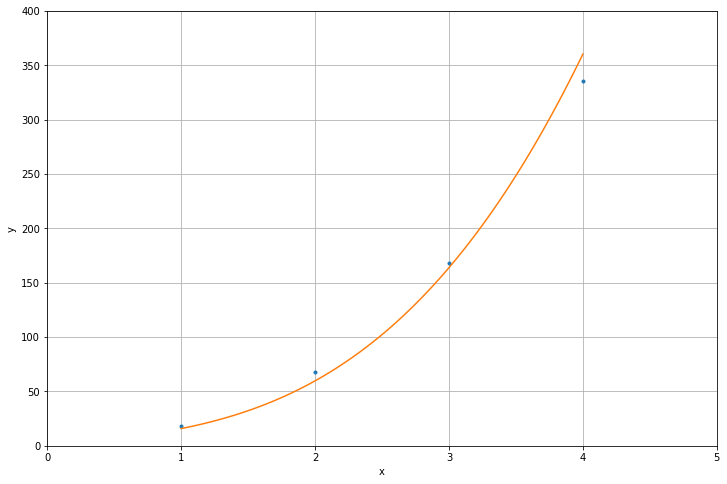

In [24]:
poly = np.poly1d(np.array([5.35749, -2.04348, 12.5266, 0], dtype='float64'))
xin = np.array([1, 2, 3, 4], dtype='float64')
yin = np.array([18, 68, 168, 336], dtype='float64')
xp = np.linspace(1, 4, 100)

plt.rc('figure', figsize=(12, 8))
plt.plot(xin, yin, '.', xp, poly(xp), '-')
plt.xlim(0, 5)
plt.ylim(0, 400)
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

# Exercises

1. Extend the class `Matrix` to be an arbitrary dimensional array.
2. Develop your own matrix-matrix multiplication code, measure the runtime, and
compare with that of BLAS ``DGEMM`` subroutine.  The matrix size should be
larger than or equal to :math:`1000\times1000`.

# References

* BLAS: http://www.netlib.org/blas/
* LAPACK: http://www.netlib.org/lapack/